In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib import rc
from scipy.special import expit
from keras.datasets import mnist

rc('text', usetex=True)
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')

font = {'family' : 'monospace',
        'size'   : 24,
        'weight' : 'heavy'
       }

rc('font', **font)

%config InlineBackend.figure_formats = ['svg']

2023-11-07 20:40:24.351193: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Download MNIST

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [3]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009]))

### Transform to `float`

In [4]:
X_train = X_train.reshape((-1, 784)).astype(float) / 255
X_test = X_test.reshape((-1, 784)).astype(float) / 255

In [5]:
X_train.dtype, X_test.dtype

(dtype('float64'), dtype('float64'))

### Split train into train and val

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10000, random_state=429)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((50000, 784), (10000, 784), (10000, 784), (50000,), (10000,), (10000,))

### Plot digits and their classes

In [7]:
def plot_digits(X, y_true, y_pred=None, n=4, random_state=123):
    np.random.seed(random_state)
    indices = np.random.choice(np.arange(X.shape[0]), size=n*n, replace=False)
    plt.figure(figsize=(10, 10))
    for i in range(n*n):
        plt.subplot(n, n, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[indices[i]].reshape(28, 28), cmap='gray')
        # plt.imshow(train_images[i], cmap=plt.cm.binary)
        if y_pred is None:
            title = str(y_true[indices[i]])
        else:
            title = f"y={y_true[indices[i]]}, ŷ={y_pred[indices[i]]}"
        plt.title(title, size=20)
    plt.show()

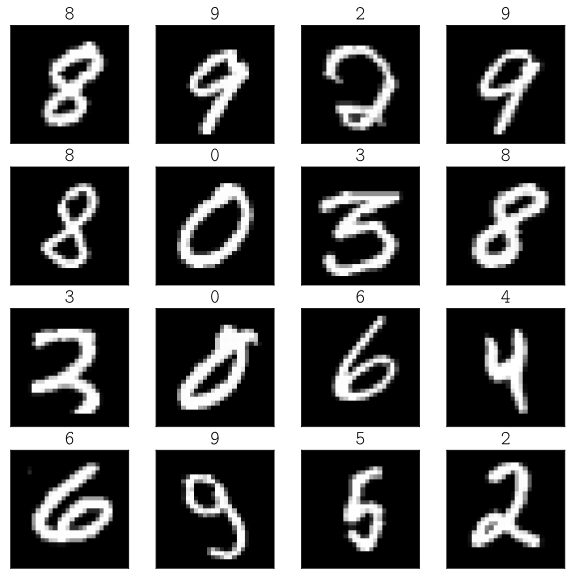

In [8]:
plot_digits(X_train, y_train, random_state=56)

### Transform targets via one hot encoding

In [9]:
from keras.utils import to_categorical

num_classes = 10

y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

y_train.shape, y_val.shape, y_test.shape

((50000, 10), (10000, 10), (10000, 10))

In [11]:
y_test[-10:]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

## Build simple NN using `Keras`

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Input
from keras.optimizers import SGD, Adam
from keras.callbacks import LearningRateScheduler
from keras import backend as K

In [13]:
model = Sequential()
model.add(Input(shape=(784,)))
model.add(Dense(392, activation='relu'))
model.add(Dense(196, activation='relu'))
model.add(Dense(10, activation='softmax'))

optimizer = SGD(learning_rate=0.03, momentum=0.0, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

2023-04-07 19:33:24.906686: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 392)               307720    
                                                                 
 dense_1 (Dense)             (None, 196)               77028     
                                                                 
 dense_2 (Dense)             (None, 10)                1970      
                                                                 
Total params: 386,718
Trainable params: 386,718
Non-trainable params: 0
_________________________________________________________________


### Train NN with 2 hidden layers using `SGD`

In [14]:
history_sgd = model.fit(X_train, y_train, batch_size=100, epochs=30, validation_data=(X_val, y_val))

Epoch 1/30
500/500 [==============================] - 16s 29ms/step - loss: 0.6455 - accuracy: 0.8352 - val_loss: 0.3621 - val_accuracy: 0.8938
Epoch 2/30
500/500 [==============================] - 14s 29ms/step - loss: 0.2945 - accuracy: 0.9172 - val_loss: 0.2813 - val_accuracy: 0.9166
Epoch 3/30
500/500 [==============================] - 14s 28ms/step - loss: 0.2408 - accuracy: 0.9322 - val_loss: 0.2394 - val_accuracy: 0.9323
Epoch 4/30
500/500 [==============================] - 15s 30ms/step - loss: 0.2062 - accuracy: 0.9417 - val_loss: 0.2217 - val_accuracy: 0.9361
Epoch 5/30
500/500 [==============================] - 13s 26ms/step - loss: 0.1812 - accuracy: 0.9489 - val_loss: 0.1956 - val_accuracy: 0.9436
Epoch 6/30
500/500 [==============================] - 11s 21ms/step - loss: 0.1612 - accuracy: 0.9543 - val_loss: 0.1809 - val_accuracy: 0.9474
Epoch 7/30
500/500 [==============================] - 14s 28ms/step - loss: 0.1450 - accuracy: 0.9593 - val_loss: 0.1644 - val_accuracy:

KeyboardInterrupt: 

### Evaluate accuracy on the test sample

In [16]:
scores = model.evaluate(X_test, y_test)
print("Test loss:", scores[0])
print("Test accuracy:", scores[1])

313/313 [==============================] - 4s 14ms/step - loss: 0.0949 - accuracy: 0.9705
Test loss: 0.09485713392496109
Test accuracy: 0.9704999923706055


### Train the same model with momentum

In [17]:
model = Sequential()
model.add(Input(shape=(784,)))
model.add(Dense(392, activation='relu'))
model.add(Dense(196, activation='relu'))
model.add(Dense(10, activation='softmax'))

optimizer = SGD(learning_rate=0.03, momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history_sgd_momentum = model.fit(X_train, y_train, batch_size=100, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
500/500 [==============================] - 13s 22ms/step - loss: 0.3043 - accuracy: 0.9111 - val_loss: 0.1666 - val_accuracy: 0.9498
Epoch 2/20
500/500 [==============================] - 14s 27ms/step - loss: 0.1186 - accuracy: 0.9647 - val_loss: 0.1247 - val_accuracy: 0.9628
Epoch 3/20
500/500 [==============================] - 17s 34ms/step - loss: 0.0762 - accuracy: 0.9763 - val_loss: 0.1071 - val_accuracy: 0.9681
Epoch 4/20
500/500 [==============================] - 15s 30ms/step - loss: 0.0560 - accuracy: 0.9829 - val_loss: 0.0905 - val_accuracy: 0.9740
Epoch 5/20
500/500 [==============================] - 14s 28ms/step - loss: 0.0401 - accuracy: 0.9879 - val_loss: 0.0948 - val_accuracy: 0.9725
Epoch 6/20
500/500 [==============================] - 14s 27ms/step - loss: 0.0297 - accuracy: 0.9912 - val_loss: 0.0912 - val_accuracy: 0.9748
Epoch 7/20
500/500 [==============================] - 13s 26ms/step - loss: 0.0228 - accuracy: 0.9933 - val_loss: 0.0844 - val_accuracy:

In [18]:
scores = model.evaluate(X_test, y_test)
print("Test loss:", scores[0])
print("Test accuracy:", scores[1])

313/313 [==============================] - 5s 13ms/step - loss: 0.0720 - accuracy: 0.9819
Test loss: 0.07204189151525497
Test accuracy: 0.9818999767303467


### Now use `Adam` optimizer

In [19]:
model = Sequential()
model.add(Input(shape=(784,)))
model.add(Dense(392, activation='relu'))
model.add(Dense(196, activation='relu'))
model.add(Dense(10, activation='softmax'))

optimizer = Adam(learning_rate=3*1e-4)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history_adam = model.fit(X_train, y_train, batch_size=100, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
500/500 [==============================] - 18s 30ms/step - loss: 0.3701 - accuracy: 0.8999 - val_loss: 0.2040 - val_accuracy: 0.9398
Epoch 2/20
500/500 [==============================] - 16s 32ms/step - loss: 0.1460 - accuracy: 0.9580 - val_loss: 0.1422 - val_accuracy: 0.9587
Epoch 3/20
500/500 [==============================] - 13s 25ms/step - loss: 0.1011 - accuracy: 0.9703 - val_loss: 0.1126 - val_accuracy: 0.9661
Epoch 4/20
500/500 [==============================] - 10s 21ms/step - loss: 0.0764 - accuracy: 0.9777 - val_loss: 0.1100 - val_accuracy: 0.9650
Epoch 5/20
500/500 [==============================] - 15s 30ms/step - loss: 0.0593 - accuracy: 0.9830 - val_loss: 0.0961 - val_accuracy: 0.9694
Epoch 6/20
500/500 [==============================] - 16s 32ms/step - loss: 0.0451 - accuracy: 0.9871 - val_loss: 0.0891 - val_accuracy: 0.9736
Epoch 7/20
500/500 [==============================] - 12s 25ms/step - loss: 0.0363 - accuracy: 0.9893 - val_loss: 0.0898 - val_accuracy:

In [20]:
scores = model.evaluate(X_test, y_test)
print("Test loss:", scores[0])
print("Test accuracy:", scores[1])

313/313 [==============================] - 5s 14ms/step - loss: 0.0868 - accuracy: 0.9790
Test loss: 0.0868433266878128
Test accuracy: 0.9789999723434448


In [21]:
def plot_histories(histories, labels, metric):
    plt.figure(figsize=(10, 6))
    colors = ['r', 'b', 'g', 'orange', 'brown', 'y', ]
    for i, history in enumerate(histories):
        plt.plot(history[metric], lw=2, ls="--", c=colors[i], label=labels[i] + ", train")
        plt.plot(history['val_'+metric], lw=2, c=colors[i], label=labels[i] + ", val")
    plt.grid(ls=":")
    plt.legend()
    plt.xlabel("epoch")
    plt.title(metric)

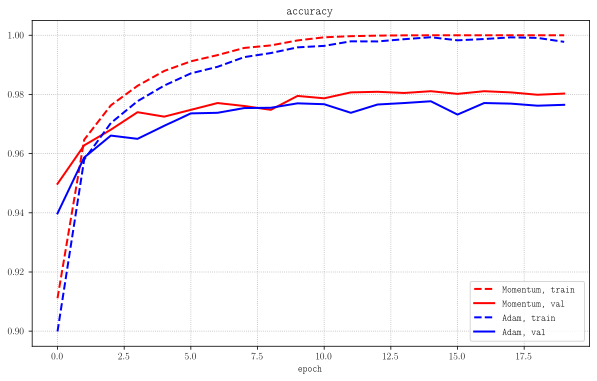

In [25]:
histories = [history_sgd_momentum.history, history_adam.history]
labels = ["Momentum", "Adam"]
plot_histories(histories, labels, 'accuracy')

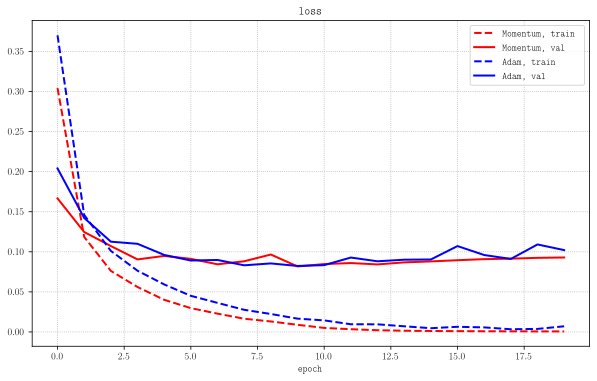

In [26]:
plot_histories(histories, labels, 'loss')

## Learning rate decay

In [27]:
def build_model(layer_dims, opt, lr, activation='relu'):
    """
        @param: layer_dims, sequence of integers
            Dimensions of hidden layers
        @param: opt, str
            Optimizer — SGD or Adam
        @param: lr, float
            Learning rate
    """
    model = Sequential()
    model.add(Input(shape=(784,)))
    for dim in layer_dims:
        model.add(Dense(dim, activation=activation))
    model.add(Dense(10, activation='softmax'))
    if opt == 'sgd':
        optimizer = SGD(learning_rate=lr, momentum=0.9)
    elif opt == 'Adam':
        optimizer = Adam(learning_rate=lr)
    else:
        raise ValueError(f"Unknown optimizer: {opt}")
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [28]:
model = build_model([392, 196], 'Adam', 0.01)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 392)               307720    
                                                                 
 dense_10 (Dense)            (None, 196)               77028     
                                                                 
 dense_11 (Dense)            (None, 10)                1970      
                                                                 
Total params: 386,718
Trainable params: 386,718
Non-trainable params: 0
_________________________________________________________________


### Train a model with `Adam` optimizer shinking learning rate every 6 epochs

In [29]:
epochs_decay = 6
def scheduler(epoch):
    if (epoch + epochs_decay // 2) % epochs_decay == 0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, 0.5 * lr)
        print("lr changed to {}".format(0.5 * lr))
    return K.get_value(model.optimizer.lr)

history_adam = model.fit(X_train, y_train, batch_size=100, epochs=30, validation_data=(X_val, y_val),
                    callbacks=LearningRateScheduler(scheduler))

Epoch 1/30
500/500 [==============================] - 15s 28ms/step - loss: 0.2483 - accuracy: 0.9275 - val_loss: 0.1884 - val_accuracy: 0.9466 - lr: 0.0100
Epoch 2/30
500/500 [==============================] - 13s 26ms/step - loss: 0.1349 - accuracy: 0.9618 - val_loss: 0.1564 - val_accuracy: 0.9577 - lr: 0.0100
Epoch 3/30
500/500 [==============================] - 12s 24ms/step - loss: 0.1105 - accuracy: 0.9679 - val_loss: 0.1551 - val_accuracy: 0.9586 - lr: 0.0100
lr changed to 0.004999999888241291
Epoch 4/30
500/500 [==============================] - 14s 28ms/step - loss: 0.0562 - accuracy: 0.9829 - val_loss: 0.1107 - val_accuracy: 0.9716 - lr: 0.0050
Epoch 5/30
500/500 [==============================] - 13s 27ms/step - loss: 0.0375 - accuracy: 0.9883 - val_loss: 0.1285 - val_accuracy: 0.9707 - lr: 0.0050
Epoch 6/30
500/500 [==============================] - 14s 27ms/step - loss: 0.0356 - accuracy: 0.9887 - val_loss: 0.1177 - val_accuracy: 0.9727 - lr: 0.0050
Epoch 7/30
500/500 [===

In [30]:
scores = model.evaluate(X_test, y_test)
print("Test loss:", scores[0])
print("Test accuracy:", scores[1])

313/313 [==============================] - 4s 11ms/step - loss: 0.1619 - accuracy: 0.9818
Test loss: 0.1618986874818802
Test accuracy: 0.9818000197410583


### Do the same thing with `SGD`

In [94]:
model = build_model([392, 196], 'sgd', 0.2)
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 392)               307720    
                                                                 
 dense_43 (Dense)            (None, 196)               77028     
                                                                 
 dense_44 (Dense)            (None, 10)                1970      
                                                                 
Total params: 386,718
Trainable params: 386,718
Non-trainable params: 0
_________________________________________________________________


In [95]:
history_sgd = model.fit(X_train, y_train, batch_size=100, epochs=30, validation_data=(X_val, y_val),
                    callbacks=LearningRateScheduler(scheduler))

Epoch 1/30
500/500 [==============================] - 4s 7ms/step - loss: 0.2645 - accuracy: 0.9200 - val_loss: 0.1750 - val_accuracy: 0.9491 - lr: 0.2000
Epoch 2/30
500/500 [==============================] - 3s 7ms/step - loss: 0.1273 - accuracy: 0.9623 - val_loss: 0.1328 - val_accuracy: 0.9635 - lr: 0.2000
Epoch 3/30
500/500 [==============================] - 4s 8ms/step - loss: 0.0957 - accuracy: 0.9715 - val_loss: 0.1460 - val_accuracy: 0.9617 - lr: 0.2000
lr changed to 0.10000000149011612
Epoch 4/30
500/500 [==============================] - 3s 7ms/step - loss: 0.0423 - accuracy: 0.9870 - val_loss: 0.0887 - val_accuracy: 0.9763 - lr: 0.1000
Epoch 5/30
500/500 [==============================] - 4s 7ms/step - loss: 0.0245 - accuracy: 0.9923 - val_loss: 0.0894 - val_accuracy: 0.9781 - lr: 0.1000
Epoch 6/30
500/500 [==============================] - 3s 7ms/step - loss: 0.0152 - accuracy: 0.9953 - val_loss: 0.0900 - val_accuracy: 0.9794 - lr: 0.1000
Epoch 7/30
500/500 [================

In [96]:
scores = model.evaluate(X_test, y_test)
print("Test loss:", scores[0])
print("Test accuracy:", scores[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.0932 - accuracy: 0.9832
Test loss: 0.09322898834943771
Test accuracy: 0.9832000136375427


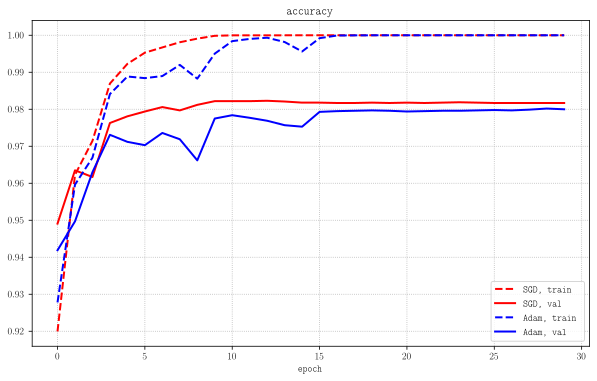

In [100]:
histories = [history_sgd.history, history_adam.history]
labels = ["SGD", "Adam"]
plot_histories(histories, labels, 'accuracy')

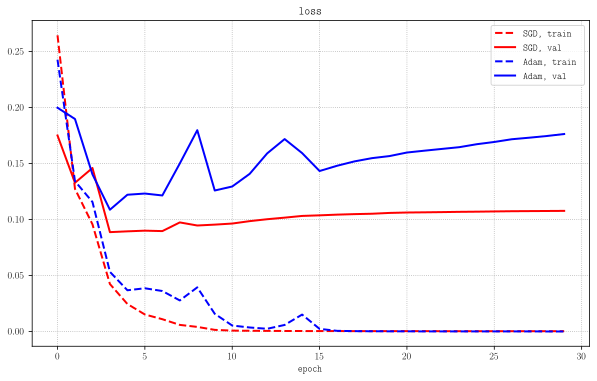

In [101]:
plot_histories(histories, labels, 'loss')